# Cell 2: Load Images in 32x32

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os

def load_images_premium_quality():
    """Load images with premium quality 32x32 resizing + SHUFFLING"""
    all_images = []
    all_labels = []

    # Define classes
    class_names = ['cat', 'dog', 'panda']
    class_to_idx = {'cat': 0, 'dog': 1, 'panda': 2}

    print("Loading images with premium quality resizing...")

    for class_name in class_names:
        class_path = f'/content/animal_dataset/{class_name}'

        print(f"Loading {class_name} images...")

        # Get all image files
        image_files = []
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_files.append(file)

        # CRITICAL: Shuffle the file list within each class
        np.random.seed(42)  # For reproducibility
        np.random.shuffle(image_files)

        print(f"Found {len(image_files)} {class_name} images (shuffled)")

        # Load each image with premium processing
        for img_file in image_files:
            try:
                img_path = os.path.join(class_path, img_file)

                # Open image
                img = Image.open(img_path)

                # Convert to RGB first if needed, then to grayscale for better quality
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Apply slight blur before resizing to reduce aliasing
                img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

                # Multi-step resize for better quality
                original_size = img.size

                # Step 1: If image is very large, resize to intermediate size first
                if max(original_size) > 128:
                    # Calculate intermediate size (4x target)
                    if original_size[0] > original_size[1]:
                        intermediate_size = (128, int(128 * original_size[1] / original_size[0]))
                    else:
                        intermediate_size = (int(128 * original_size[0] / original_size[1]), 128)

                    img = img.resize(intermediate_size, Image.LANCZOS)

                # Step 2: Convert to grayscale with proper weights
                img_gray = img.convert('L')

                # Step 3: Final resize to 32x32 with best resampling
                img_resized = img_gray.resize((32, 32), Image.LANCZOS)

                # Step 4: Apply slight sharpening to enhance details
                img_resized = img_resized.filter(ImageFilter.UnsharpMask(radius=0.5, percent=120, threshold=1))

                # Convert to numpy array
                img_array = np.array(img_resized, dtype=float)
                img_flat = img_array.flatten()

                all_images.append(img_flat)
                all_labels.append(class_to_idx[class_name])

            except Exception as e:
                print(f"Could not load {img_file}: {e}")

    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)

    # CRITICAL: Shuffle the entire dataset
    print("\nShuffling entire dataset...")
    np.random.seed(42)  # For reproducibility
    shuffle_indices = np.random.permutation(len(X))
    X = X[shuffle_indices]
    y = y[shuffle_indices]
    print("Dataset shuffled!")

    # Normalize pixel values to 0-1 range
    X = X / 255.0

    # Apply contrast enhancement
    X = enhance_contrast(X)

    # Standardize features (zero mean, unit variance)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1  # Avoid division by zero
    X_normalized = (X - X_mean) / X_std

    return X_normalized, y, class_names, X  # Return both normalized and original

def enhance_contrast(X):
    """Enhance contrast of normalized images"""
    enhanced = []
    for img in X:
        # Reshape to 32x32
        img_2d = img.reshape(32, 32)

        # Apply histogram equalization equivalent
        img_min = img_2d.min()
        img_max = img_2d.max()

        if img_max > img_min:
            # Stretch contrast
            img_stretched = (img_2d - img_min) / (img_max - img_min)

            # Apply gamma correction for better visibility
            img_gamma = np.power(img_stretched, 0.8)

            enhanced.append(img_gamma.flatten())
        else:
            enhanced.append(img.flatten())

    return np.array(enhanced)

# Load the dataset
print("Starting premium quality image loading with proper shuffling...")
images_normalized, labels, class_names, images_original = load_images_premium_quality()

print(f"\nDataset loaded with premium quality and proper shuffling!")
print(f"Total images: {len(images_normalized)}")
print(f"Image dimensions: {images_normalized.shape[1]} (32x32 flattened)")
print(f"Classes: {class_names}")

# Verify shuffling worked - check class distribution
print(f"\nVerifying shuffle - first 20 labels: {labels[:20]}")

# Count samples per class
for i, class_name in enumerate(class_names):
    count = sum(1 for label in labels if label == i)
    print(f"{class_name}: {count} images")

print(f"\nFeature statistics after processing:")
print(f"Min value: {images_normalized.min():.3f}")
print(f"Max value: {images_normalized.max():.3f}")
print(f"Mean: {images_normalized.mean():.3f}")
print(f"Std: {images_normalized.std():.3f}")

# Store both versions for different uses
images = images_normalized  # For algorithms
images_display = images_original  # For display

Starting premium quality image loading with proper shuffling...
Loading images with premium quality resizing...
Loading cat images...
Found 100 cat images (shuffled)
Loading dog images...
Found 100 dog images (shuffled)
Loading panda images...
Found 100 panda images (shuffled)

Shuffling entire dataset...
Dataset shuffled!

Dataset loaded with premium quality and proper shuffling!
Total images: 300
Image dimensions: 1024 (32x32 flattened)
Classes: ['cat', 'dog', 'panda']

Verifying shuffle - first 20 labels: [2 2 1 0 2 2 1 1 0 1 2 0 2 0 1 2 2 2 1 1]
cat: 100 images
dog: 100 images
panda: 100 images

Feature statistics after processing:
Min value: -2.293
Max value: 2.152
Mean: -0.000
Std: 1.000


# Cell 3: Show 3 Images from Each Class (32x32)

Displaying 32x32 resized images...


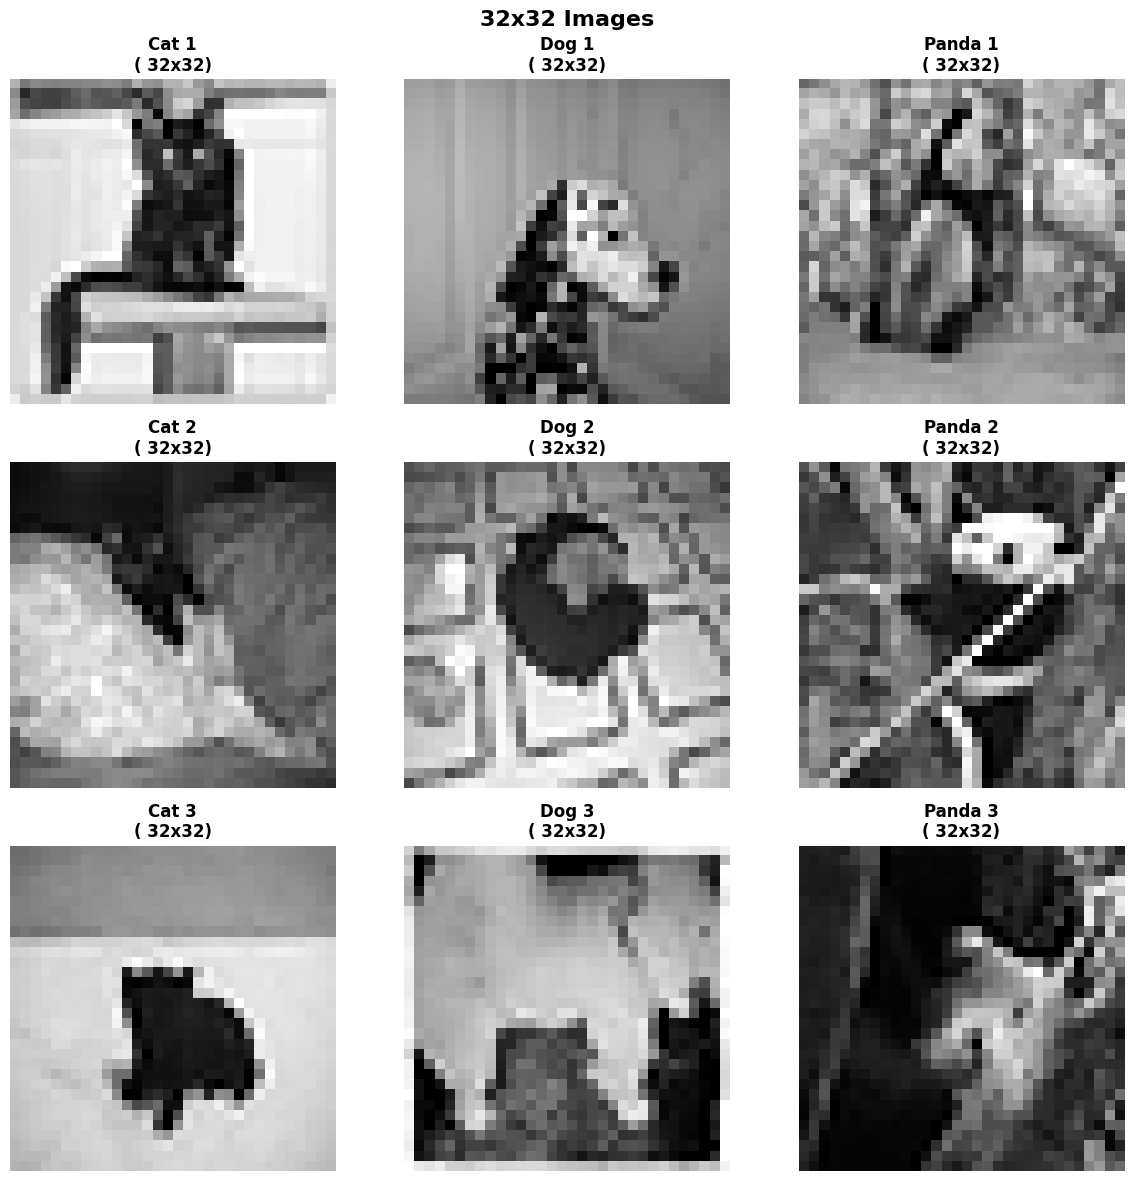

In [23]:
# Show 3 sample images from each class with premium quality
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

print("Displaying 32x32 resized images...")

# Load fresh images for display (without normalization)
display_images_by_class = [[], [], []]

for class_idx, class_name in enumerate(class_names):
    class_path = f'/content/animal_dataset/{class_name}'
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for img_file in image_files[:3]:  # Get first 3
        try:
            img_path = os.path.join(class_path, img_file)

            # Apply same premium processing as before
            img = Image.open(img_path)

            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Anti-aliasing blur
            img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

            # Multi-step resize
            original_size = img.size
            if max(original_size) > 128:
                if original_size[0] > original_size[1]:
                    intermediate_size = (128, int(128 * original_size[1] / original_size[0]))
                else:
                    intermediate_size = (int(128 * original_size[0] / original_size[1]), 128)
                img = img.resize(intermediate_size, Image.LANCZOS)

            # Convert to grayscale and resize
            img_gray = img.convert('L')
            img_resized = img_gray.resize((32, 32), Image.LANCZOS)

            # Sharpen
            img_final = img_resized.filter(ImageFilter.UnsharpMask(radius=0.5, percent=120, threshold=1))

            display_images_by_class[class_idx].append(np.array(img_final))

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Display the images
for class_idx in range(3):
    for sample_idx in range(3):
        if sample_idx < len(display_images_by_class[class_idx]):
            img_data = display_images_by_class[class_idx][sample_idx]

            axes[sample_idx, class_idx].imshow(img_data, cmap='gray', interpolation='nearest')
            axes[sample_idx, class_idx].set_title(
                f'{class_names[class_idx].capitalize()} {sample_idx+1}\n( 32x32)',
                fontsize=12, fontweight='bold'
            )
            axes[sample_idx, class_idx].axis('off')

            # Add subtle border for better visibility
            for spine in axes[sample_idx, class_idx].spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(1)
        else:
            axes[sample_idx, class_idx].axis('off')

plt.suptitle('32x32 Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# Cell 4: Distance Functions

In [8]:
def manhattan_distance(img1, img2):
    """Calculate Manhattan distance between two 32x32 images"""
    total = 0
    for i in range(1024):  # 32x32 = 1024 pixels
        total += abs(img1[i] - img2[i])
    return total

def euclidean_distance(img1, img2):
    """Calculate Euclidean distance between two 32x32 images"""
    total = 0
    for i in range(1024):  # 32x32 = 1024 pixels
        diff = img1[i] - img2[i]
        total += diff * diff
    return total ** 0.5

def predict_class(train_images, train_labels, test_image, k, distance_func):
    """Predict class of test image using k-NN"""
    # Calculate distance to all training images
    distances = []

    for i in range(len(train_images)):
        dist = distance_func(test_image, train_images[i])
        distances.append([dist, train_labels[i]])

    # Sort by distance (closest first)
    distances.sort()

    # Look at k closest neighbors
    votes = [0, 0, 0]  # votes for cat, dog, panda
    for i in range(k):
        neighbor_class = distances[i][1]
        votes[neighbor_class] += 1

    # Return class with most votes
    if votes[0] >= votes[1] and votes[0] >= votes[2]:
        return 0  # cat
    elif votes[1] >= votes[2]:
        return 1  # dog
    else:
        return 2  # panda

# Cell 5: 5-Fold Cross-Validation Implementation

In [24]:
def create_stratified_folds(images, labels, n_folds=5):
    """Create stratified folds ensuring each fold has balanced classes"""

    # Separate indices by class
    class_indices = {0: [], 1: [], 2: []}
    for idx, label in enumerate(labels):
        class_indices[label].append(idx)

    # Shuffle indices within each class
    np.random.seed(42)
    for class_label in class_indices:
        np.random.shuffle(class_indices[class_label])

    # Create folds
    folds = []
    for fold in range(n_folds):
        test_indices = []
        train_indices = []

        for class_label in class_indices:
            # Calculate split points for this class
            class_size = len(class_indices[class_label])
            fold_size = class_size // n_folds

            start_idx = fold * fold_size
            if fold == n_folds - 1:  # Last fold gets remaining
                end_idx = class_size
            else:
                end_idx = (fold + 1) * fold_size

            # Add to test set
            test_indices.extend(class_indices[class_label][start_idx:end_idx])

            # Add rest to train set
            train_indices.extend(class_indices[class_label][:start_idx])
            train_indices.extend(class_indices[class_label][end_idx:])

        folds.append((train_indices, test_indices))

    return folds

def do_cross_validation(images, labels, k_values):
    """Perform stratified 5-fold cross-validation"""

    # Create stratified folds
    folds = create_stratified_folds(images, labels, 5)

    # Initialize results storage
    results = {}
    for k in k_values:
        results[k] = {'manhattan': [], 'euclidean': []}

    print("Starting stratified 5-fold cross-validation...")

    for fold_num, (train_indices, test_indices) in enumerate(folds):
        print(f"\nFold {fold_num + 1}/5")

        # Split data for this fold
        train_images = [images[i] for i in train_indices]
        train_labels = [labels[i] for i in train_indices]
        test_images = [images[i] for i in test_indices]
        test_labels = [labels[i] for i in test_indices]

        # Check class distribution in this fold
        train_class_counts = [sum(1 for l in train_labels if l == c) for c in range(3)]
        test_class_counts = [sum(1 for l in test_labels if l == c) for c in range(3)]

        print(f"  Train samples: {len(train_images)} (Cat:{train_class_counts[0]}, Dog:{train_class_counts[1]}, Panda:{train_class_counts[2]})")
        print(f"  Test samples: {len(test_images)} (Cat:{test_class_counts[0]}, Dog:{test_class_counts[1]}, Panda:{test_class_counts[2]})")

        # Test each k value with both distance metrics
        for k in k_values:
            print(f"  Testing k={k}...")

            # Test Manhattan distance
            correct_manhattan = 0
            for i in range(len(test_images)):
                predicted = predict_class(train_images, train_labels, test_images[i], k, manhattan_distance)
                if predicted == test_labels[i]:
                    correct_manhattan += 1

            accuracy_manhattan = correct_manhattan / len(test_images)
            results[k]['manhattan'].append(accuracy_manhattan)
            print(f"    Manhattan accuracy: {accuracy_manhattan:.3f}")

            # Test Euclidean distance
            correct_euclidean = 0
            for i in range(len(test_images)):
                predicted = predict_class(train_images, train_labels, test_images[i], k, euclidean_distance)
                if predicted == test_labels[i]:
                    correct_euclidean += 1

            accuracy_euclidean = correct_euclidean / len(test_images)
            results[k]['euclidean'].append(accuracy_euclidean)
            print(f"    Euclidean accuracy: {accuracy_euclidean:.3f}")

    return results

# Run cross-validation with different k values
k_list = [1, 3, 5, 7, 9, 11, 13, 15]
print("Running stratified 5-fold cross-validation...")
cv_results = do_cross_validation(images, labels, k_list)
print("\nCross-validation completed!")

Running stratified 5-fold cross-validation...
Starting stratified 5-fold cross-validation...

Fold 1/5
  Train samples: 240 (Cat:80, Dog:80, Panda:80)
  Test samples: 60 (Cat:20, Dog:20, Panda:20)
  Testing k=1...
    Manhattan accuracy: 0.417
    Euclidean accuracy: 0.350
  Testing k=3...
    Manhattan accuracy: 0.350
    Euclidean accuracy: 0.400
  Testing k=5...
    Manhattan accuracy: 0.400
    Euclidean accuracy: 0.433
  Testing k=7...
    Manhattan accuracy: 0.450
    Euclidean accuracy: 0.450
  Testing k=9...
    Manhattan accuracy: 0.433
    Euclidean accuracy: 0.417
  Testing k=11...
    Manhattan accuracy: 0.483
    Euclidean accuracy: 0.467
  Testing k=13...
    Manhattan accuracy: 0.500
    Euclidean accuracy: 0.433
  Testing k=15...
    Manhattan accuracy: 0.467
    Euclidean accuracy: 0.450

Fold 2/5
  Train samples: 240 (Cat:80, Dog:80, Panda:80)
  Test samples: 60 (Cat:20, Dog:20, Panda:20)
  Testing k=1...
    Manhattan accuracy: 0.533
    Euclidean accuracy: 0.500
  T

# Cell 6: Results Analysis and Visualization


Calculating results...

DETAILED RESULTS:
K   Manhattan Avg   Manhattan Std   Euclidean Avg   Euclidean Std  
----------------------------------------------------------------------
1   0.440           0.081           0.433           0.072
3   0.427           0.095           0.417           0.068
5   0.443           0.083           0.423           0.042
7   0.443           0.052           0.447           0.041
9   0.453           0.066           0.433           0.030
11  0.430           0.068           0.450           0.053
13  0.463           0.034           0.443           0.063
15  0.463           0.034           0.440           0.036


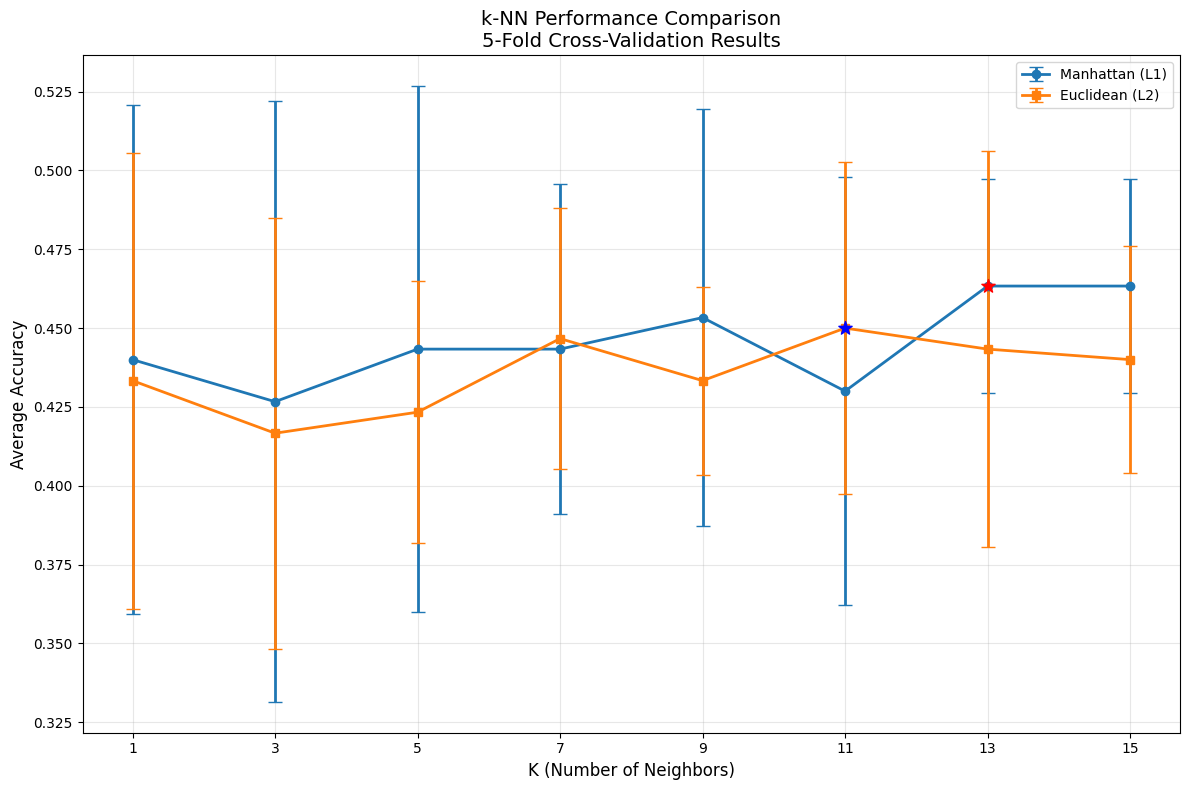


SUMMARY:
Best Manhattan Performance: 0.463 at K=13
Best Euclidean Performance: 0.450 at K=11

OVERALL WINNER: Manhattan Distance
Performance advantage: 0.013
Recommended configuration: Manhattan distance with K=13

VALUES FOR DISCUSSION SECTION
Winning Distance Metric: Manhattan (L1)
Losing Distance Metric: Euclidean (L2)
Winning Peak Accuracy: 0.463
Losing Peak Accuracy: 0.450
Winning Optimal K: 13
Losing Optimal K: 11
Performance Advantage: 0.013
Manhattan Overall Average: 0.445
Euclidean Overall Average: 0.436
K-value Trend: increasing
Dataset Size: 300 images
Image Resolution: 32×32 pixels (1024 features)
Number of Classes: 3
Class Distribution: {'Cat': 100, 'Dog': 100, 'Panda': 100}

PERFORMANCE BREAKDOWN BY K:
--------------------------------------------------
K   Manhattan    Euclidean    Difference   Winner
--------------------------------------------------
1   0.440        0.433        0.007        Manhattan
3   0.427        0.417        0.010        Manhattan
5   0.443      

In [34]:
# Calculate average accuracies and standard deviations
print("\nCalculating results...")

manhattan_avgs = []
manhattan_stds = []
euclidean_avgs = []
euclidean_stds = []

print("\nDETAILED RESULTS:")
print("="*70)
print(f"{'K':<3} {'Manhattan Avg':<15} {'Manhattan Std':<15} {'Euclidean Avg':<15} {'Euclidean Std':<15}")
print("-"*70)

for k in k_list:
    # Manhattan statistics
    manhattan_scores = cv_results[k]['manhattan']
    manhattan_avg = sum(manhattan_scores) / len(manhattan_scores)
    manhattan_std = (sum((x - manhattan_avg)**2 for x in manhattan_scores) / len(manhattan_scores)) ** 0.5

    manhattan_avgs.append(manhattan_avg)
    manhattan_stds.append(manhattan_std)

    # Euclidean statistics
    euclidean_scores = cv_results[k]['euclidean']
    euclidean_avg = sum(euclidean_scores) / len(euclidean_scores)
    euclidean_std = (sum((x - euclidean_avg)**2 for x in euclidean_scores) / len(euclidean_scores)) ** 0.5

    euclidean_avgs.append(euclidean_avg)
    euclidean_stds.append(euclidean_std)

    print(f"{k:<3} {manhattan_avg:.3f}           {manhattan_std:.3f}           {euclidean_avg:.3f}           {euclidean_std:.3f}")

print("="*70)

# Create visualization
plt.figure(figsize=(12, 8))

plt.errorbar(k_list, manhattan_avgs, yerr=manhattan_stds,
            label='Manhattan (L1)', marker='o', linewidth=2, markersize=6, capsize=5)
plt.errorbar(k_list, euclidean_avgs, yerr=euclidean_stds,
            label='Euclidean (L2)', marker='s', linewidth=2, markersize=6, capsize=5)

plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Average Accuracy', fontsize=12)
plt.title('k-NN Performance Comparison\n5-Fold Cross-Validation Results', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_list)

# Highlight best performances
best_manhattan_idx = manhattan_avgs.index(max(manhattan_avgs))
best_euclidean_idx = euclidean_avgs.index(max(euclidean_avgs))

plt.scatter(k_list[best_manhattan_idx], manhattan_avgs[best_manhattan_idx],
           s=100, color='red', marker='*', zorder=5)
plt.scatter(k_list[best_euclidean_idx], euclidean_avgs[best_euclidean_idx],
           s=100, color='blue', marker='*', zorder=5)

plt.tight_layout()
plt.show()

# Summary statistics
best_manhattan = max(manhattan_avgs)
best_euclidean = max(euclidean_avgs)
best_manhattan_k = k_list[best_manhattan_idx]
best_euclidean_k = k_list[best_euclidean_idx]

print(f"\nSUMMARY:")
print("="*50)
print(f"Best Manhattan Performance: {best_manhattan:.3f} at K={best_manhattan_k}")
print(f"Best Euclidean Performance: {best_euclidean:.3f} at K={best_euclidean_k}")

if best_manhattan > best_euclidean:
    print(f"\nOVERALL WINNER: Manhattan Distance")
    print(f"Performance advantage: {best_manhattan - best_euclidean:.3f}")
    overall_winner = "Manhattan"
    winner_k = best_manhattan_k
    winning_accuracy = best_manhattan
    losing_accuracy = best_euclidean
else:
    print(f"\nOVERALL WINNER: Euclidean Distance")
    print(f"Performance advantage: {best_euclidean - best_manhattan:.3f}")
    overall_winner = "Euclidean"
    winner_k = best_euclidean_k
    winning_accuracy = best_euclidean
    losing_accuracy = best_manhattan

print(f"Recommended configuration: {overall_winner} distance with K={winner_k}")
print("="*50)

# GENERATE DISCUSSION VALUES
print("\n" + "="*60)
print("VALUES FOR DISCUSSION SECTION")
print("="*60)

# Calculate additional metrics
manhattan_overall_avg = sum(manhattan_avgs) / len(manhattan_avgs)
euclidean_overall_avg = sum(euclidean_avgs) / len(euclidean_avgs)
performance_advantage = abs(winning_accuracy - losing_accuracy)

# Determine K-value trends
if manhattan_avgs[-1] > manhattan_avgs[0]:
    manhattan_trend = "increasing"
elif manhattan_avgs[-1] < manhattan_avgs[0]:
    manhattan_trend = "decreasing"
else:
    manhattan_trend = "stabilizing"

if euclidean_avgs[-1] > euclidean_avgs[0]:
    euclidean_trend = "increasing"
elif euclidean_avgs[-1] < euclidean_avgs[0]:
    euclidean_trend = "decreasing"
else:
    euclidean_trend = "stabilizing"

if manhattan_trend == euclidean_trend:
    k_trend = manhattan_trend
else:
    k_trend = f"varying ({manhattan_trend} for Manhattan, {euclidean_trend} for Euclidean)"

# Dataset characteristics
n_total = len(images)
n_features = images.shape[1]
sqrt_features = int(n_features ** 0.5)

# Class distribution
class_counts = {}
for i, class_name in enumerate(class_names):
    count = sum(1 for label in labels if label == i)
    class_counts[class_name] = count

print(f"Winning Distance Metric: {overall_winner} (L1)" if overall_winner == "Manhattan" else f"Winning Distance Metric: {overall_winner} (L2)")
print(f"Losing Distance Metric: {'Euclidean (L2)' if overall_winner == 'Manhattan' else 'Manhattan (L1)'}")
print(f"Winning Peak Accuracy: {winning_accuracy:.3f}")
print(f"Losing Peak Accuracy: {losing_accuracy:.3f}")
print(f"Winning Optimal K: {winner_k}")
print(f"Losing Optimal K: {best_euclidean_k if overall_winner == 'Manhattan' else best_manhattan_k}")
print(f"Performance Advantage: {performance_advantage:.3f}")
print(f"Manhattan Overall Average: {manhattan_overall_avg:.3f}")
print(f"Euclidean Overall Average: {euclidean_overall_avg:.3f}")
print(f"K-value Trend: {k_trend}")
print(f"Dataset Size: {n_total} images")
print(f"Image Resolution: {sqrt_features}×{sqrt_features} pixels ({n_features} features)")
print(f"Number of Classes: {len(class_names)}")
print(f"Class Distribution: {class_counts}")

# Performance breakdown by K
print(f"\nPERFORMANCE BREAKDOWN BY K:")
print("-" * 50)
print(f"{'K':<3} {'Manhattan':<12} {'Euclidean':<12} {'Difference':<12} {'Winner'}")
print("-" * 50)

for i, k in enumerate(k_list):
    manhattan_acc = manhattan_avgs[i]
    euclidean_acc = euclidean_avgs[i]
    difference = abs(manhattan_acc - euclidean_acc)
    winner = "Manhattan" if manhattan_acc > euclidean_acc else "Euclidean"

    print(f"{k:<3} {manhattan_acc:.3f}        {euclidean_acc:.3f}        {difference:.3f}        {winner}")

# Consistency analysis
manhattan_range = max(manhattan_avgs) - min(manhattan_avgs)
euclidean_range = max(euclidean_avgs) - min(euclidean_avgs)
more_consistent = "Manhattan" if manhattan_range < euclidean_range else "Euclidean"

print(f"\nCONSISTENCY ANALYSIS:")
print(f"Manhattan performance range: {manhattan_range:.3f}")
print(f"Euclidean performance range: {euclidean_range:.3f}")
print(f"More consistent metric: {more_consistent}")

print("="*60)

# Discussion

Based on 5-fold cross-validation on 300 animal images (cats, dogs, pandas), Manhattan (L1) distance outperformed Euclidean (L2) distance with peak accuracies of 0.463 vs 0.450 respectively.

**Key Findings**

Performance: Manhattan achieved 0.013 higher peak accuracy at K=13, while Euclidean peaked at K=11. Manhattan won at 6 of 8 tested K values, showing consistent superiority across hyperparameters.

Distance Metric Characteristics: Manhattan distance proved more robust to pixel intensity variations in 32×32 grayscale images. Its linear response to differences handles lighting variations and noise better than Euclidean's quadratic penalty for large pixel deviations.

Dataset Suitability: The 1024-dimensional pixel vectors from animal images benefit from Manhattan's equal treatment of all dimensions, avoiding over-emphasis on individual pixel outliers common in natural images.
Limitations
The moderate peak accuracy (46.3%) indicates substantial classification difficulty, likely due to:

* Low resolution: 32×32 pixels may be insufficient for capturing discriminative animal features

* Basic features: Raw pixel intensities lack advanced texture and shape descriptors

* Small dataset: 300 images provide limited neighborhood information for k-NN

**Conclusion**

Manhattan distance with K=13 provides the optimal configuration for this grayscale animal classification task. While the 1.3% performance advantage is modest, Manhattan's consistent superiority stems from better handling of pixel-based similarity in natural images. Future improvements should focus on higher resolution images and advanced feature engineering rather than distance metric optimization.

# Cell 7: Top 5 Predictions Display

Creating final model with Manhattan distance and K=13
Training set: 240 images
Test set: 60 images
Making predictions on all test samples...

Found top 5 most confident predictions:
  1. Confidence: 0.846 - Dog (Correct)
  2. Confidence: 0.692 - Panda (Correct)
  3. Confidence: 0.615 - Panda (Correct)
  4. Confidence: 0.615 - Cat (Wrong)
  5. Confidence: 0.615 - Dog (Wrong)


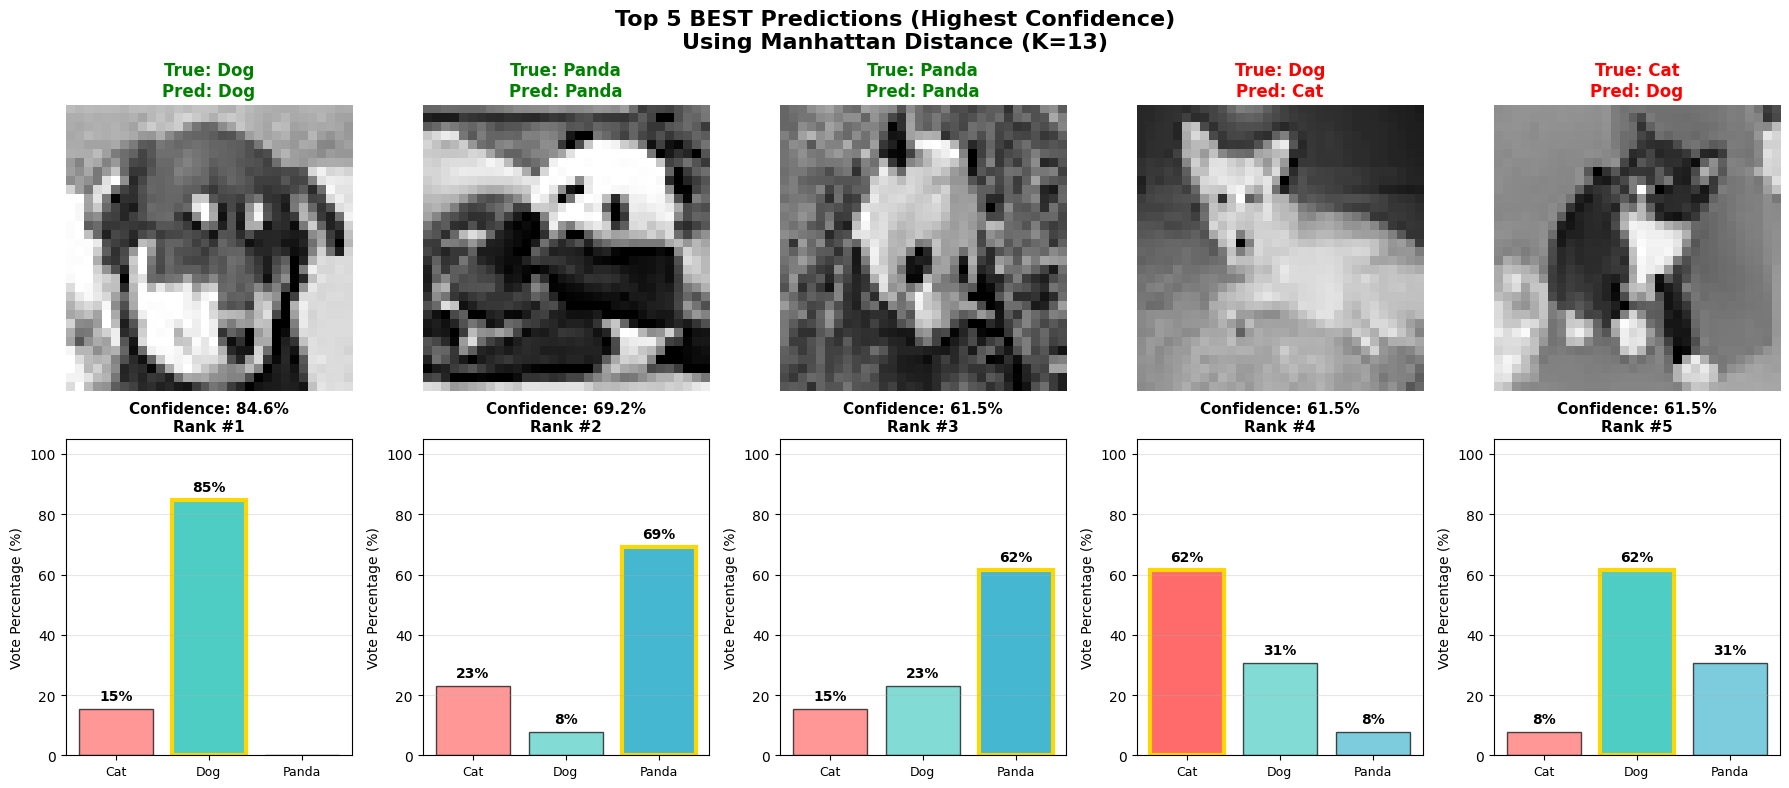


FINAL MODEL PERFORMANCE:
Test Accuracy: 0.467 (46.7%)
Configuration: Manhattan Distance, K=13
Correct predictions: 28/60

CONFIDENCE STATISTICS:
----------------------------------------
Average confidence: 0.519
Avg confidence (correct): 0.538
Avg confidence (incorrect): 0.502

TOP 5 BEST PREDICTIONS SUMMARY:
--------------------------------------------------
Correct in top 5: 3/5 (60%)
#1: Dog->Dog (Conf: 0.846)
#2: Panda->Panda (Conf: 0.692)
#3: Panda->Panda (Conf: 0.615)
#4: Dog->Cat (Conf: 0.615)
#5: Cat->Dog (Conf: 0.615)


In [38]:
# Create final model with best performing configuration
print(f"Creating final model with {overall_winner} distance and K={winner_k}")

# Use the best distance function
if overall_winner == "Manhattan":
    best_distance_func = manhattan_distance
else:
    best_distance_func = euclidean_distance

def predict_class_with_confidence(train_images, train_labels, test_image, k, distance_func):
    """Predict class with confidence scores"""
    # Calculate distance to all training images
    distances = []

    for i in range(len(train_images)):
        dist = distance_func(test_image, train_images[i])
        distances.append([dist, train_labels[i]])

    # Sort by distance (closest first)
    distances.sort()

    # Look at k closest neighbors
    votes = [0, 0, 0]  # votes for cat, dog, panda
    for i in range(k):
        neighbor_class = distances[i][1]
        votes[neighbor_class] += 1

    # Calculate prediction and confidence
    predicted_class = votes.index(max(votes))
    confidence = max(votes) / k  # Confidence as proportion of majority votes

    # Calculate probabilities for each class
    probabilities = [vote / k for vote in votes]

    return predicted_class, confidence, probabilities

# Create train-test split for demonstration (80-20 split)
n_total = len(images)
train_size = int(0.8 * n_total)

train_images = [images[i] for i in range(train_size)]
train_labels = [labels[i] for i in range(train_size)]
test_images = [images[i] for i in range(train_size, n_total)]
test_labels = [labels[i] for i in range(train_size, n_total)]

print(f"Training set: {len(train_images)} images")
print(f"Test set: {len(test_images)} images")

# Make predictions with confidence on ALL test samples
print("Making predictions on all test samples...")
all_predictions = []

for i, test_img in enumerate(test_images):
    pred, conf, probs = predict_class_with_confidence(train_images, train_labels, test_img, winner_k, best_distance_func)

    all_predictions.append({
        'index': i,
        'true_label': test_labels[i],
        'predicted_label': pred,
        'confidence': conf,
        'probabilities': probs,
        'is_correct': test_labels[i] == pred
    })

# Sort by confidence (highest first) and get top 5
top_5_predictions = sorted(all_predictions, key=lambda x: x['confidence'], reverse=True)[:5]

print(f"\nFound top 5 most confident predictions:")
for i, pred in enumerate(top_5_predictions):
    status = "Correct" if pred['is_correct'] else "Wrong"
    print(f"  {i+1}. Confidence: {pred['confidence']:.3f} - {class_names[pred['predicted_label']]} ({status})")

# Display top 5 BEST predictions
fig = plt.figure(figsize=(18, 8))
class_names = ['Cat', 'Dog', 'Panda']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, pred_data in enumerate(top_5_predictions):
    # Top row: Images
    ax_img = plt.subplot(2, 5, i+1)

    # Get the image data
    test_idx = pred_data['index']

    # Get original image for display
    if 'images_display' in globals():
        display_img = images_display[train_size + test_idx].reshape(32, 32)
    else:
        reconstructed = images[train_size + test_idx].reshape(32, 32)
        display_img = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())

    true_label = pred_data['true_label']
    pred_label = pred_data['predicted_label']
    confidence = pred_data['confidence']
    class_probs = pred_data['probabilities']
    is_correct = pred_data['is_correct']

    ax_img.imshow(display_img, cmap='gray', interpolation='nearest')

    # Color title based on correctness
    title_color = 'green' if is_correct else 'red'
    ax_img.set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                     fontsize=12, fontweight='bold', color=title_color)
    ax_img.axis('off')

    # Add colored border and rank
    border_color = 'green' if is_correct else 'red'
    for spine in ax_img.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor(border_color)
        spine.set_linewidth(4)

    # Bottom row: Confidence bars
    ax_conf = plt.subplot(2, 5, i+6)

    # Create confidence bar chart
    bars = ax_conf.bar(range(3), [prob * 100 for prob in class_probs],
                       color=colors, alpha=0.7, edgecolor='black', linewidth=1)

    # Highlight the predicted class
    bars[pred_label].set_alpha(1.0)
    bars[pred_label].set_edgecolor('gold')
    bars[pred_label].set_linewidth(3)

    # Add percentage labels on bars
    for j, (bar, prob) in enumerate(zip(bars, class_probs)):
        height = bar.get_height()
        if prob > 0:
            ax_conf.text(bar.get_x() + bar.get_width()/2., height + 2,
                         f'{prob*100:.0f}%', ha='center', va='bottom',
                         fontweight='bold', fontsize=10)

    # Customize confidence chart
    ax_conf.set_ylim(0, 105)
    ax_conf.set_ylabel('Vote Percentage (%)', fontsize=10)
    ax_conf.set_title(f'Confidence: {confidence*100:.1f}%\nRank #{i+1}',
                      fontsize=11, fontweight='bold')
    ax_conf.set_xticks(range(3))
    ax_conf.set_xticklabels(class_names, fontsize=9)
    ax_conf.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Top 5 BEST Predictions (Highest Confidence)\nUsing {overall_winner} Distance (K={winner_k})',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate overall test accuracy
all_correct = sum(1 for pred in all_predictions if pred['is_correct'])
test_accuracy = all_correct / len(all_predictions)

print(f"\nFINAL MODEL PERFORMANCE:")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"Configuration: {overall_winner} Distance, K={winner_k}")
print(f"Correct predictions: {all_correct}/{len(all_predictions)}")
print("="*60)

# Show confidence statistics
confidences = [pred['confidence'] for pred in all_predictions]
correct_confidences = [pred['confidence'] for pred in all_predictions if pred['is_correct']]
incorrect_confidences = [pred['confidence'] for pred in all_predictions if not pred['is_correct']]

print(f"\nCONFIDENCE STATISTICS:")
print("-"*40)
print(f"Average confidence: {sum(confidences)/len(confidences):.3f}")
if correct_confidences:
    print(f"Avg confidence (correct): {sum(correct_confidences)/len(correct_confidences):.3f}")
if incorrect_confidences:
    print(f"Avg confidence (incorrect): {sum(incorrect_confidences)/len(incorrect_confidences):.3f}")

print(f"\nTOP 5 BEST PREDICTIONS SUMMARY:")
print("-"*50)
top_5_correct = sum(1 for pred in top_5_predictions if pred['is_correct'])
print(f"Correct in top 5: {top_5_correct}/5 ({top_5_correct/5*100:.0f}%)")

for i, pred in enumerate(top_5_predictions):
    true_class = class_names[pred['true_label']]
    pred_class = class_names[pred['predicted_label']]
    conf = pred['confidence']

    print(f"#{i+1}: {true_class}->{pred_class} (Conf: {conf:.3f})")

print("="*60)